# Deep Q-Network for Navigation
**Michael Santoro - michael.santoro@du.edu**
# Introduction
Drawing from the research presented in the [Deep Q-Learning](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf) a unity envrioment will be used to train a human like player to plat the banana capture game. Where a player moved around and picks up yellow bananas to pick up a point and and avoid blue bananas that make the player lose a point. Leveraging the unity enviroment allows for a bit of system simiplification. In the information printed from the enviroment outputs below we see that there are 4 discrete actions and discrete state space of 37. This is a bit of naive method since there is not really known about what this vector space represents. For instance does it represent speed, the pixel method in the paper would include information about the changes in state.

In [2]:
from unityagents import UnityEnvironment
import numpy as np
from collections import deque
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
## Load the Unity Enviroment
env = UnityEnvironment(file_name='Banana_Windows_x86_64\\Banana_Windows_x86_64\\Banana.exe')


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have shape',state.shape)


Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have shape (37,)


# Learning Algorithim
## Agent
Next, using the information from the enviroment we create the agent which consists of the following key components:
1. ReplayBuffer - Fixed size buffer to store experience tuples which stores the state, action, reward, next_state, and done.
2. QNetwork Local - Nueral Network (NN) with an input size of the state and output size of the action space. It includes two hidden layers with 64 units. Resulting in a feed forward Nueral Network. Used to store the current best policy.
3. QNetwork Target - Similar NN architecture to 'QNetwork Local'. Gets trained on batches from the ReplayBuffer.

In [6]:
from dqn_agent import Agent

agent = Agent(state_size=37, action_size=4, seed=0)

## DQN Process
A fixed window of 100 scores will be used as an average to analyze how our agent is training. For each of our defined experiments we start a new session. Then we take action either until we reach the set threshold or the session is ended. In this step the following occurs.
1. Get Action from the current policy
1. Play the action and get the enviroment info
1. Step the Agent
    1. Add the state next state relationship to the memory buffer
    1. If the step is an update_entry window (in this case we are updating every 4-steps) and the replay buffer has more entries than the batch size, then weights are updated in the current policy
1. After Session End
    1. Scores are added to buffer
    1. eps is reduced (As more sessions are completed the agent should be getting better so we would like to reduce the probability of random actions.

Episode 100	Average Score: 0.63
Episode 200	Average Score: 3.95
Episode 300	Average Score: 7.73
Episode 400	Average Score: 10.10
Episode 500	Average Score: 12.81
Episode 527	Average Score: 13.07
Environment solved in 427 episodes!	Average Score: 13.07


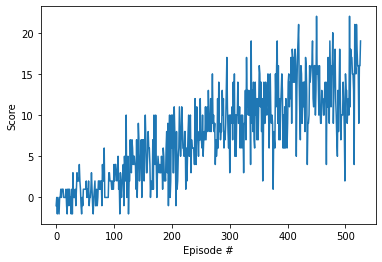

In [7]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0]            # get the current state
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps) #Select an Action
            action = action.astype(np.int32)
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

scores = dqn()


# Plot of Rewards

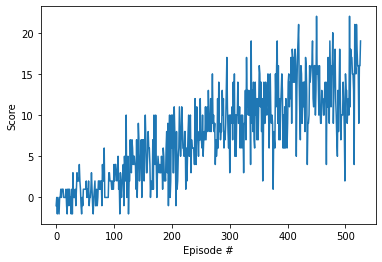

In [8]:
env.close()
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## View the Trained Agents Play

In [3]:
## Note Notebook may need to be restarted before running this cell
env = UnityEnvironment(file_name='Banana_Windows_x86_64\\Banana_Windows_x86_64\\Banana.exe')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [4]:
from dqn_agent import Agent

agent = Agent(state_size=37, action_size=4, seed=0)

# load the weights from file
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

for i in range(3):
    env_info = env.reset(train_mode=False)[brain_name] # reset the environment
    state = env_info.vector_observations[0]            # get the current state
    for j in range(200):
        action = agent.act(state) #Select an Action
        action = action.astype(np.int32)
        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations[0]   # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]                  # see if episode has finished
        agent.step(state, action, reward, next_state, done)
        state = next_state
        if done:
            break 
            
env.close()

# Ideas for Future Work
It can be seen there seam to be some cases where the agent learned that it could cyle a back and forth manuever. Here some possible future work to make this agent play the banana game even better could be the following.
1. [Double Deep Q-Learning](https://arxiv.org/abs/1509.06461) - If we credit this jittery behavior observed as the agent plays to overestimate action values. We can try the idea behind the Double Q-learning algorithm. Which is that the max operator in standard Q-learning and DQN, uses the same values both to select and to evaluate an action. This makes it more likely to select overestimated values, resulting in overoptimistic value estimates. To prevent this, there can be a decoupling from the selection to the evaluation.
1. [The Dueling Network Architecture](https://arxiv.org/abs/1511.06581) - The key insight behind this architecture, is that for many states, it is unnecessary to estimate the value of each action choice. So, if we feel that we would like to take action only if a collision is eminent. To bring this insight to fruition, we design a single Qnetwork architecture, which we refer to as the dueling network. The lower layers of the dueling network are convolutional as in the original DQNs. However, instead of following the convolutional layers with a single sequence of fully connected layers, we instead use two sequences (or streams) of fully connected layers. The streams are constructed such that they have they have the capability of providing separate estimates of the value and advantage functions. This should give us the difference in behavior we are hoping for.